In [1]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#imports
import math
import numpy as np 
import matplotlib.pyplot as plt 
import torch

In [3]:
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco, NeumannBoco
from nangs.solutions import MLP

class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None, order=2):
        super().__init__(inputs, outputs, order=order)
    def computePDELoss(self, grads, inputs, outputs, params): 
        dpdt = grads['p']['t']
        d2pdx2 = grads['2p']['xx']
        return [dpdt - d2pdx2]
    
# instanciate pde
pde = MyPDE(inputs=['x', 't'], outputs=['p'])

# define input values
x = np.linspace(0, 1, 10)

t = np.linspace(0, 10, 10)

pde.setValues({'x': x, 't': t})

In [4]:
# initial condition (dirichlet for temporal dimension)
p0 = np.full(len(x[1:-1]), 0)       
boco = DirichletBoco('initial_condition', {'x': x[1:-1], 't': np.array([0])}, {'p': p0})
pde.addBoco(boco)



boco = DirichletBoco('left', {'x': x[:1], 't': t}, {'p': np.full(len(t), 0.0)})
pde.addBoco(boco)

boco = DirichletBoco('right', {'x': x[-1:], 't': t}, {'p': np.full(len(t), 1.0)})
pde.addBoco(boco)

In [5]:
# define solution topology
mlp = MLP(pde.n_inputs, pde.n_outputs, 5, 256)
optimizer = torch.optim.Adam(mlp.parameters(), lr=3e-4)
pde.compile(mlp, optimizer)

In [6]:
# find the solution
hist = pde.solve(epochs=50) 

/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


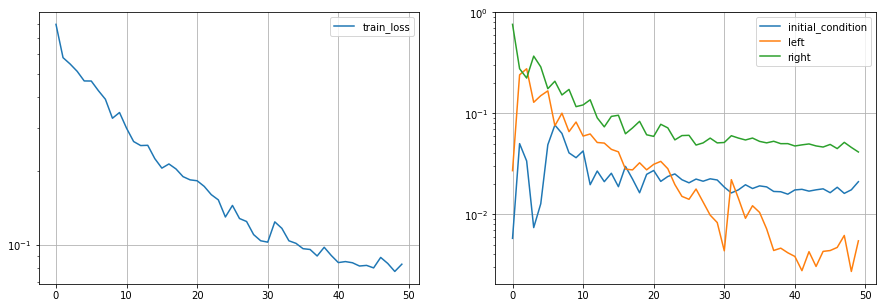

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(hist['train_loss'], label="train_loss")
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
for boco in pde.bocos:
    ax2.plot(hist['bocos'][boco.name], label=boco.name)
ax2.legend()
ax2.grid(True)
ax2.set_yscale("log")
plt.show()

In [8]:
# evaluate the solution
x = np.linspace(0, 1, 10)

t = np.linspace(0, 10, 10)
p = []
for _t in t:
    pde.evaluate({'x': x, 't': np.array([_t])})
    _p = pde.outputs['p']
    p.append(_p)

a = p[0]
file = open("heat1D.txt", "w")
s = 0
for e in range(0, 10):
    a = p[e]
    file.write("t = "+str(e)+"\n")
    for i in range(0, 10):
        file.write(str(i)+", "+str(a[s])+"\n")
        s += 1

    s = 0
file.close() 

file = open("heat1Dexact.txt", "w")
for e in range(0, 10):
    file.write("t = "+str(e)+"\n")
    for i in range(0, 10):
        file.write(str(i)+", "+str(np.sin(math.pi * i * 0.1 / 2.0) * math.exp(-math.pi**2 * e / 4)) + "\n")
        
file.close()
    


In [9]:
anim

NameError: name 'anim' is not defined

In [17]:
print(np.shape(p))

(100, 400)
